# ML Workshop: Generating Text using an N-gram Model

## What is an N-gram Model?

An $N$-gram model is a simple but powerful tool used in natural language processing (NLP) for predicting the next word in a sequence of words. It's based on the idea that the probability of a word occurring depends on the previous $N-1$ words in the sequence.

## How Does it Work?

Imagine we have a sentence: "The quick brown fox jumps". 

- A unigram model ($N=1$) predicts the next word based on the probability of individual words. For example, given "The", it might predict "quick" with high probability because "quick" often follows "The".
- A bigram model ($N=2$) predicts the next word based on the probability of pairs of words. For example, given "quick brown", it might predict "fox" because "fox" often follows "quick brown".
- An $N$-gram model generalizes this concept to predict the next word based on the probability of the previous $N-1$ words.

## Model Architecture

In our workshop, we'll create a simple $N$-gram model using PyTorch. Here's a simplified overview of the architecture:

1. **Tokenization**: We'll convert our text data into tokens (words or characters).
2. **Embedding**: Each token is represented as a high-dimensional vector (embedding).
3. **Concatenation**: We concatenate the embeddings of the previous $N-1$ tokens into a single vector.
4. **Fully-Connected Layers**: We pass the concatenated vector through fully-connected layers with activation functions like ReLU.
5. **Output Layer**: Finally, we predict the probability distribution over the vocabulary to determine the next token.

## Workshop Goals

By the end of this workshop, you'll understand the basics of $N$-gram models and how they can be implemented using PyTorch. You'll also be able to train your own model and generate text based on the patterns it learns from the training data.

Let's dive in and explore the world of NLP with $N$-gram models!

---

*Author: Shivam Gupta*

*GitHub Repository: [shivamCode0/ngram](https://github.com/shivamCode0/ngram)*


### Imports and Setup (Run this block first)


In [1]:
%pip install torchinfo
%pip install torchviz

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from abc import ABC, abstractmethod

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# download file to tmp/data.txt
!wget -O data.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-03-02 01:11:06--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'data.txt'

     0K .......... .......... .......... .......... ..........  4% 4.74M 0s
    50K .......... .......... .......... .......... ..........  9% 11.3M 0s
   100K .......... .......... .......... .......... .......... 13% 14.3M 0s
   150K .......... .......... .......... .......... .......... 18% 42.8M 0s
   200K .......... .......... .......... .......... .......... 22% 16.4M 0s
   250K .......... .......... .......... .......... .......... 27% 33.1M 0s
   300K .......... .......... .......... .......... .......... 32% 78.6M 0s
   350

### 1. Load & Preprocess Dataset

In [5]:
with open('data.txt', 'r') as f:
    text = f.read()
print('text length:', len(text))

text length: 1115394


⚠️⚠️⚠️ Print first 100 characters of text ⚠️⚠️⚠️


In [6]:
# TODO: print first 100 characters of text
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [7]:
chars = ["[PAD]", *sorted(list(set(text)))]
vocab_size = len(chars)
print("".join(chars))
print("vocab size:", vocab_size)

[PAD]
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 66


In [8]:
# Create mapping from character to index and vice versa
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

⚠️⚠️⚠️ Verify that `encode` and `decode` work ⚠️⚠️⚠️

In [9]:
print(decode(encode("Welcome to Hack the Treasure")))

Welcome to Hack the Treasure


In [10]:
# store in tensor
data = torch.tensor(encode(text), dtype=torch.int64, device=device)
print(data.shape, data.dtype)
print(data[:100]) # the 100 characters we looked at earier will to the GPT look like this
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
block_size = 100
train_data[:block_size+1]
a = train_data[:block_size]
y = train_data[1:block_size+1]
torch.manual_seed(1337)
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 10 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape, xb.dtype, xb.device)
print('targets:')
print(yb.shape, yb.dtype, yb.device)

torch.Size([1115394]) torch.int64
tensor([19, 48, 57, 58, 59,  2, 16, 48, 59, 48, 65, 44, 53, 11,  1, 15, 44, 45,
        54, 57, 44,  2, 62, 44,  2, 55, 57, 54, 42, 44, 44, 43,  2, 40, 53, 64,
         2, 45, 60, 57, 59, 47, 44, 57,  7,  2, 47, 44, 40, 57,  2, 52, 44,  2,
        58, 55, 44, 40, 50,  9,  1,  1, 14, 51, 51, 11,  1, 32, 55, 44, 40, 50,
         7,  2, 58, 55, 44, 40, 50,  9,  1,  1, 19, 48, 57, 58, 59,  2, 16, 48,
        59, 48, 65, 44, 53, 11,  1, 38, 54, 60], device='cuda:0')
inputs:
torch.Size([32, 10]) torch.int64 cuda:0
targets:
torch.Size([32, 10]) torch.int64 cuda:0


### 2. Define the Model

In [11]:
class BaseNGram(nn.Module, ABC):
    def __init__(self, vocab_size, n):
        super().__init__()
        super().to(device)
        assert n >= 3, "n should be at least 3"

    @abstractmethod
    def run_calculations(self, x):
        # to be implemented in child classes
        pass
    
    # Create separate function for forward calculation
    def forward(self, x, only_last=False):
        assert len(x.shape) == 2, "input shape should be (batch, time)"

        if only_last:
            # pad time dim to at least n
            x = x[:, -self.n :]
            x = F.pad(x, (self.n - x.shape[1], 0), value=0)
            B, N = x.shape
            x = x.view(B, 1, N)
        else:
            new_x = torch.zeros((x.shape[0], x.shape[1], self.n), dtype=torch.int64, device=device) - 69
            for time_index in range(x.shape[1]):
                row = x[:, max(0, time_index - self.n + 1) : time_index + 1]
                row = F.pad(row, (self.n - row.shape[1], 0), value=0)
                new_x[:, time_index] = row
            x = new_x

        return self.run_calculations(x)

    @abstractmethod
    def loss_func(self, y_true, y_pred):
        # to be implemented in child classes
        pass
   
    def loss(self, logits, targets):
        B, T, C = logits.shape
        logits_flat = logits.view(B * T, C)
        loss = self.loss_func(targets.view(B * T), logits_flat)
        return loss

⚠️⚠️⚠️ Define the model here. ⚠️⚠️⚠️

In [12]:
class MyModel(BaseNGram):
    def __init__(self, vocab_size, n):
        super().__init__(vocab_size, n)
        self.n = n
        embedding_size = 50 # ⚠️ Set this to 50
        intermediate_size = 120 # ⚠️ Set this to 120
        self.token_embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        # ⚠️ Create fc layer with input size of embedding_size * n and output size of intermediate_size
        self.fc = nn.Linear(embedding_size * n, intermediate_size)
        # ⚠️ 20% dropout
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.final = nn.Linear(intermediate_size, vocab_size)
    
    def run_calculations(self, x):
        x = self.token_embedding(x) # ⚠️ pass x through the embedding layer

        # Flatten the input (already done for you)
        x = x.view(x.shape[0], x.shape[1], -1)

        # ⚠️ Pass x through the rest of the layers
        x = self.fc(x) 
        x = self.relu(x)
        x = self.dropout(x)
        x = self.final(x)

        return x
    
    def loss_func(self, y_true, y_pred):
        # ⚠️ Use cross entropy loss
        loss = F.cross_entropy(y_pred, y_true)
        return loss
    
    def generate(self, x, max_len_new, temperature=1.0):
        for _ in range(max_len_new):
            logits = self(x, True)[:, -1] / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            x = torch.cat([x, next_token], dim=1)

        return x

In [13]:
# ⚠️ Instantiate the model
model = MyModel(vocab_size, 7)


summary(
    model,
    input_data=[torch.zeros((256, 10), dtype=torch.long, device=device), True],
    verbose=2,
    device=device,
    col_names=["input_size", "output_size", "num_params", "mult_adds"],
)
model.to(device)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
MyModel                                  [256, 10]                 [256, 1, 66]              --                        --
├─Embedding: 1-1                         [256, 1, 7]               [256, 1, 7, 50]           3,300                     844,800
│    └─weight                                                                                └─3,300
├─Linear: 1-2                            [256, 1, 350]             [256, 1, 120]             42,120                    10,782,720
│    └─weight                                                                                ├─42,000
│    └─bias                                                                                  └─120
├─ReLU: 1-3                              [256, 1, 120]             [256, 1, 120]             --                        --
├─Dropout: 1-4                           [256, 1, 120]             [

MyModel(
  (token_embedding): Embedding(66, 50, padding_idx=0)
  (fc): Linear(in_features=350, out_features=120, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (final): Linear(in_features=120, out_features=66, bias=True)
)

In [14]:
print(model)
# logits, loss = model(xb, yb)
logits = model(xb)
loss = model.loss(logits, yb)
print('logits:', logits.shape)
print('loss:', loss)

print(decode(model.generate(xb, 10)[0].tolist()))

MyModel(
  (token_embedding): Embedding(66, 50, padding_idx=0)
  (fc): Linear(in_features=350, out_features=120, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (final): Linear(in_features=120, out_features=66, bias=True)
)
logits: torch.Size([32, 10, 66])
loss: tensor(4.1650, device='cuda:0', grad_fn=<NllLossBackward0>)
rch o' theewCQjv-eYj


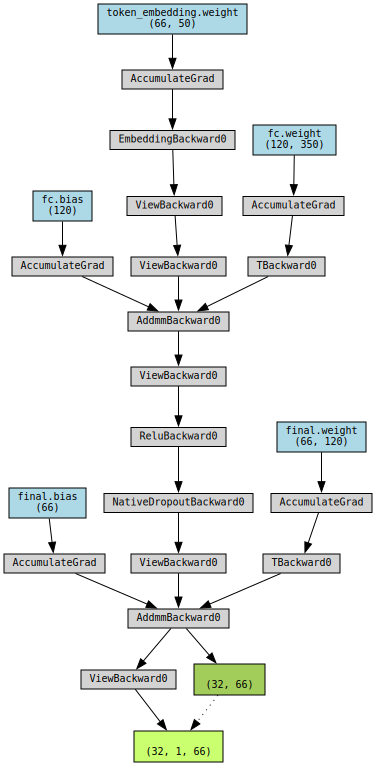

In [15]:
make_dot(model(xb, True), params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

In [16]:
# train the model
optimizer = optim.AdamW(model.parameters(), lr=0.01)
batch_size = 256
for step in range(1000):
    xb, yb = get_batch('train')
    # logits, loss = model(xb, yb)
    logits = model(xb)
    loss = model.loss(logits, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (step + 1) % 50 == 0 or step == 0:
        print(f'step: {step + 1}, loss: {loss.item():.3f}')

step: 1, loss: 4.175
step: 50, loss: 2.286
step: 100, loss: 2.089
step: 150, loss: 2.099
step: 200, loss: 2.006
step: 250, loss: 1.986
step: 300, loss: 1.979
step: 350, loss: 1.994
step: 400, loss: 1.991
step: 450, loss: 1.930
step: 500, loss: 1.933
step: 550, loss: 1.927
step: 600, loss: 1.975
step: 650, loss: 1.958
step: 700, loss: 1.954
step: 750, loss: 1.948
step: 800, loss: 1.897
step: 850, loss: 1.907
step: 900, loss: 1.889
step: 950, loss: 1.876
step: 1000, loss: 1.887


In [17]:
def generate_text(starting_text, max_length=200, temperature=0.9):
    raw = model.generate(torch.tensor([encode(starting_text)], device=device), max_length, temperature)
    return decode(raw[0].tolist())

⚠️⚠️⚠️ Print some generated text ⚠️⚠️⚠️

In [18]:
for _ in range(5):
    # ⚠️ Insert starting text
    print(generate_text("ROMEO", 200))
    print("-" * 50)

ROMEO:
Ry breatiense alergerded
Is acted worthan upos,
Rome them at refere hime be most pulys: I not
ing so anous me one the gots
Ever this, I proving,
Retous. Cictate you breich ther have forth seed not, 
--------------------------------------------------
ROMEOAUNES:
Soen thee, for thice dots, whone.

GLOUCESTER:
I foe the farty! waither,
No, you winder foucinver an do
zody net!
See, or your for his that, I deavier heart I le to Pall I hoo less
To heid the 
--------------------------------------------------
ROMEO:
Beshont in told I foltoo worthy noble which hask'd your to thou your too age thee I have that I am.

HORMy beptice; shality!

BRENNT:
What's see.

VIRGARET:
I's and wnot with dagateld this and timel
--------------------------------------------------
ROMEO:
O, to more the rean
be mereming wher too Romeoplus fromine,
That Kist Tive a dother benave I coped I it portionc
And
Beother tone!
Dest the gover.

GREANO:
Plaff condess,
Cisu rir to espand bright s
-----------------------

⚠️⚠️⚠️ Experiment Time: Try different values of `temperature` and `max_len` ⚠️⚠️⚠️

In [19]:
# You can do it!

This is the end of the tutorial part. Now, try making changes on your own and see what happens. If you need help, just ask!